# Characterization of Parkinson's Disease through clustering of Medical notes

## Introduction

### Importing packages

In [1]:
import numpy as np
import pandas as pd
import json
import re
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Imports I'm going to use again at some point

# import umap
# from wordcloud import WordCloud, STOPWORDS
# from sentence_transformers import SentenceTransformer
# from sklearn.cluster import KMeans
# from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
# from sklearn.decomposition import LatentDirichletAllocation
# from nltk.tokenize import RegexpTokenizer
# from gap_statistic import OptimalK 

## Data Pre-processing

### Exploring the data

In [2]:
path = "data/HEHE.csv" 
available_memory = 423464092  # Memory in bytes
memory_per_row = 100  # Example memory usage per row in bytes
target_memory_usage = 0.75 * available_memory
chunk_size = int(target_memory_usage / memory_per_row)
chunk_size

3175980

In [3]:
# Actual way to read large CSV files
chunk = pd.read_csv(path, chunksize=chunk_size, dtype={'dose_unit_source_value': str}) #Raises a DtypeWarning: Columns (11) have mixed types when it is not specified
df = pd.concat(chunk)

In [4]:
df.head(5)

,person_id,drug_source_value,quantity,sig,route_source_value,dose_source_value,dose_unit_source_value,note_text
0,261006,"{""med_display_name"": ""0.9 % NaCl + potassium c...",100.0,CONTINUOUS,INTRAVENOUS,100.0,mL/hr,"""[**NAME**], MD [**DATE**] 7:04 PM Depart..."
1,261006,"{""med_display_name"": ""0.9 % NaCl + potassium c...",100.0,CONTINUOUS,INTRAVENOUS,100.0,mL/hr,"""[**NAME**] [**DATE**] 9:51:05 AM Requ..."
2,261006,"{""med_display_name"": ""0.9 % NaCl bolus 1,000 m...",1000.0,BOLUS ONCE,INTRAVENOUS,1000.0,mL,"""[**NAME**], MD [**DATE**] 7:04 PM Depart..."
3,261006,"{""med_display_name"": ""0.9 % NaCl bolus 1,000 m...",1000.0,BOLUS ONCE,INTRAVENOUS,1000.0,mL,"""[**NAME**] [**DATE**] 9:51:05 AM Requ..."
4,261006,"{""med_display_name"": ""0.9 % NaCl bolus 1,000 m...",0.0,BOLUS ONCE,INTRAVENOUS,0.0,mL,"""[**NAME**], MD [**DATE**] 7:04 PM Depart..."


In [5]:
df.sample(5)

,person_id,drug_source_value,quantity,sig,route_source_value,dose_source_value,dose_unit_source_value,note_text
1090381,248934,"{""med_display_name"": ""lidocaine (PF) (XYLOCAIN...",NaN,ONCE NOW,INFILTRATION,NaN,NaN,"""[**NAME**], MD [**DATE**] 5:07 PM [**LOC..."
385129,256936,"{""med_display_name"": ""norepinephrine (LEVOPHED...",0.00,CONTINUOUS,INTRAVENOUS,0.00,mcg/kg/min,"[**NAME**], MD [**DATE**] 3:36 PM Departm..."
1363781,222938,"{""med_display_name"": ""heparin 1000 UNIT/ML inj...",0.00,ONCE,INTRAVENOUS,0.00,Units,[**NAME**] [**DATE**] 10:12 AM Consult rec...
625765,256936,"{""med_display_name"": ""vasopressin (VASOSTRICT)...",0.45,CONTINUOUS,INTRAVENOUS,0.02,Units/min,[**NAME**] [**DATE**] 3:52 PM Prosthetic ...
624447,256936,"{""med_display_name"": ""vasopressin (VASOSTRICT)...",6.15,CONTINUOUS,INTRAVENOUS,0.03,Units/min,"""[**NAME**], MD [**DATE**] 2:35 PM Depart..."


Actual len of the whole dataset. It has more than 2 Million rows

In [6]:
len(df)

2326300

#### Number of patients in this cohort

In [7]:
df['person_id'].unique().shape

(441,)

#### Dealing with the drug_source_value column

Because the drug_source_value column contains elements as json, we convert them into a dict so that we can use their original keys

In [8]:
drug_source_value = df['drug_source_value'].apply(lambda x: json.loads(x))

In [9]:
len(drug_source_value)

2326300

The keys of the dictionary are those used in the drug_source_value column

In [10]:
drug_source_value[0].keys()

dict_keys(['med_display_name', 'rxnorm_concat', 'med_dose_unit_desc', 'mar_action', 'med_order_desc'])

In [11]:
drug_source_value[865]

{'med_display_name': '0.9 % NaCl infusion',
 'rxnorm_concat': '| 313002 |',
 'med_dose_unit_desc': 'ml/hr',
 'mar_action': 'RATE VERIFY',
 'med_order_desc': 'SODIUM CHLORIDE 0.9 % IV SOLN'}

Current medication used for the treatment of Parkinson's disease

In [12]:
pd_medication = ["carbidopa", "levodopa", "entacapone", "tolcapone", "opicapone", "pramipexole", "ropinirole", "apomorphine", "rotigotine", "selegiline", "rasagiline", "safinamide", "amantadine", "istradefylline", "trihexyphenidyl", "benztropine", "bromocriptine", "cabergoline", "pergolide", "lisuride"]
pd_drug_info = {}

We look for instances of the Parkinson's drugs contained in the pd_medication array in drug_source_value so that we can focus on the medical stories relating to Parkinson's

In [13]:
for i, drug in enumerate(drug_source_value):
    for item in pd_medication:
        if item in drug_source_value[i]['med_display_name']:
            pd_drug_info[i] = drug_source_value[i]['med_display_name'] # I could have also passed the whole dictionary

Only 16K+ rows have information regarding medication for Parkinson's

In [14]:
len(pd_drug_info)

16040

The keys of this new array are the indices or rows in the original DataFrame

In [15]:
pd_drug_info.keys()

dict_keys([126, 127, 955, 956, 957, 958, 959, 960, 961, 962, 963, 964, 965, 966, 967, 968, 969, 970, 971, 972, 973, 974, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1115, 1116, 1117, 1118, 1119, 1120, 1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 1129, 1130, 1131, 1132, 1133, 1134, 1135, 1136, 1137, 1138, 1139, 1140, 1141, 1142, 1143, 1144, 1145, 1146, 1147, 1148, 1149, 1150, 1151, 1152, 1153, 1154, 1155, 1156, 1157, 1158, 1159, 1160, 1161, 1162, 1163, 1164, 1165, 1166, 1167, 1168, 1169, 1170, 1171, 1172, 1173, 1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181, 1182, 1183, 1184, 1185, 1186, 1187, 1188, 1189, 1190, 1191, 1192, 1193, 1194, 1195, 1196, 1197, 1198, 1199, 2353, 2354, 2355, 2438, 2439, 2521, 2522, 2523, 2524, 2525, 2706, 2707, 2708, 2709, 2710, 2881, 2882, 2883, 2884, 2885, 2886, 2887, 2888, 2889, 2890, 2891, 2892, 2893, 2894, 2895, 2896, 2897, 2898, 2899, 2900, 2901, 2902, 2903, 2904, 2905, 2906, 2907, 2908, 2909, 2910, 3496, 3497, 3498, 3499, 3500, 3501, 350

pd_drug_info is a subset of drug_source_value that contains the name of drugs related to PD

In [16]:
pd_drug_info[1299166]

'cabergoline (DOSTINEX) tablet 1 mg'

In [17]:
drug_source_value[1299166]

{'med_display_name': 'cabergoline (DOSTINEX) tablet 1 mg',
 'rxnorm_concat': '| 199703 |',
 'med_dose_unit_desc': 'mg',
 'mar_action': 'GIVEN',
 'med_order_desc': 'CABERGOLINE 0.5 MG PO TABS'}

Here's our new database. df_pd is a subset of the original dataset that only contains patients that are taking medication for Parkinson's

In [18]:
df_pd = df.iloc[list(pd_drug_info.keys())]
df_pd.sample(10)

,person_id,drug_source_value,quantity,sig,route_source_value,dose_source_value,dose_unit_source_value,note_text
846685,252834,"{""med_display_name"": ""carbidopa-levodopa (SINE...",1.0,3 TIMES DAILY,ORAL,1.00,tablet,"[**NAME**], RN [**DATE**] 11:07 AM Consult..."
1794520,213868,"{""med_display_name"": ""carbidopa-levodopa (SINE...",0.0,5 TIMES DAILY,ORAL,0.00,tablet,"""[**NAME**], DO [**DATE**] 9:47 AM Commun..."
1585049,220757,"{""med_display_name"": ""pramipexole (MIRAPEX) ta...",1.0,3 TIMES DAILY,ORAL,0.25,mg,"""[**NAME**], RN [**DATE**] 6:20 PM Vascul..."
1211002,244116,"{""med_display_name"": ""carbidopa-levodopa (SINE...",2.0,2 TIMES DAILY,ORAL,2.00,tablet,"[**NAME**], RN [**DATE**] 10:37 PM Consult..."
974,260996,"{""med_display_name"": ""amantadine (SYMMETREL) s...",10.0,2 TIMES DAILY,ORAL,100.00,mg,"[**NAME**], ORTHOTIST-PR [**DATE**] 6:02 ..."
858674,252733,"{""med_display_name"": ""pramipexole (MIRAPEX) ta...",2.0,3 TIMES DAILY,ORAL,0.25,mg,[**NAME**] [**DATE**] 6:14 PM Consult rec...
1299816,234554,"{""med_display_name"": ""carbidopa-levodopa (SINE...",1.0,2 TIMES DAILY,ORAL,1.00,tablet,"""[**NAME**], MD [**DATE**] 5:04 PM Depart..."
1130028,248403,"{""med_display_name"": ""carbidopa-levodopa (SINE...",0.0,4 TIMES DAILY,ORAL,0.00,tablet,"[**NAME**], RN [**DATE**] 9:13 AM Will su..."
1273678,237904,"{""med_display_name"": ""carbidopa-levodopa (SINE...",1.0,3 TIMES DAILY,ORAL,1.00,tablet,"[**NAME**], RN [**DATE**] 3:06 PM Wound c..."
2144321,195154,"{""med_display_name"": ""carbidopa-levodopa (SINE...",1.0,ONCE NOW,ORAL,1.00,Tablet,"""[**NAME**], RD [**DATE**] 4:27 PM Nutrit..."


Creating a new column

In [19]:
df_pd.insert(loc=2, column="drug_info", value=pd_drug_info)
df_pd

,person_id,drug_source_value,drug_info,quantity,sig,route_source_value,dose_source_value,dose_unit_source_value,note_text
126,261006,"{""med_display_name"": ""carbidopa-levodopa (SINE...",carbidopa-levodopa (SINEMET) 25-100 MG per tab...,2.0,EVERY 4 HOURS,ORAL,2.0,tablet,"""[**NAME**], MD [**DATE**] 7:04 PM Depart..."
127,261006,"{""med_display_name"": ""carbidopa-levodopa (SINE...",carbidopa-levodopa (SINEMET) 25-100 MG per tab...,2.0,EVERY 4 HOURS,ORAL,2.0,tablet,"""[**NAME**] [**DATE**] 9:51:05 AM Requ..."
955,260996,"{""med_display_name"": ""amantadine (SYMMETREL) c...",amantadine (SYMMETREL) capsule 100 mg,1.0,2 TIMES DAILY,ORAL,100.0,mg,"[**NAME**], ORTHOTIST-PR [**DATE**] 6:02 ..."
956,260996,"{""med_display_name"": ""amantadine (SYMMETREL) c...",amantadine (SYMMETREL) capsule 100 mg,1.0,EVERY OTHER DAY,ORAL,100.0,mg,"""[**NAME**], RD [**DATE**] 11:30 AM Nutrit..."
957,260996,"{""med_display_name"": ""amantadine (SYMMETREL) c...",amantadine (SYMMETREL) capsule 100 mg,1.0,2 TIMES DAILY,ORAL,100.0,mg,[**NAME**] [**DATE**] 7:56 PM Psychology ...
...,...,...,...,...,...,...,...,...,...
2324745,175605,"{""med_display_name"": ""carbidopa-levodopa (SINE...",carbidopa-levodopa (SINEMET) 25-100 MG per tab...,0.0,3 TIMES DAILY,ORAL,0.0,tablet,"""[**NAME**], MD [**DATE**] 1:12 PM Geriat..."
2324746,175605,"{""med_display_name"": ""carbidopa-levodopa (SINE...",carbidopa-levodopa (SINEMET) 25-100 MG per tab...,0.0,3 TIMES DAILY,ORAL,0.0,tablet,"""[**NAME**] [**DATE**] 11:30 PM Rehab Psyc..."
2324747,175605,"{""med_display_name"": ""carbidopa-levodopa (SINE...",carbidopa-levodopa (SINEMET) 25-100 MG per tab...,0.0,3 TIMES DAILY,ORAL,0.0,tablet,"""[**NAME**], RD [**DATE**] 12:48 AM Nutrit..."
2324748,175605,"{""med_display_name"": ""carbidopa-levodopa (SINE...",carbidopa-levodopa (SINEMET) 25-100 MG per tab...,0.0,3 TIMES DAILY,ORAL,0.0,tablet,"""[**NAME**], DO [**DATE**] 10:14 AM Neurol..."


In [20]:
df_pd.iloc[955]

person_id                                                            257075
drug_source_value         {"med_display_name": "carbidopa-levodopa (SINE...
drug_info                 carbidopa-levodopa (SINEMET) 12.5-125 MG per t...
quantity                                                                0.5
sig                                                           4 TIMES DAILY
route_source_value                                                     ORAL
dose_source_value                                                       0.5
dose_unit_source_value                                               tablet
note_text                 "[**NAME**], MD     [**DATE**]  9:56 PM [**LOC...
Name: 92436, dtype: object

In [21]:
df_pd.iloc[955]['drug_info']

'carbidopa-levodopa (SINEMET) 12.5-125 MG per tablet 0.5 tablet'

In [22]:
df_pd.iloc[955]['drug_source_value']

'{"med_display_name": "carbidopa-levodopa (SINEMET) 12.5-125 MG per tablet 0.5 tablet", "rxnorm_concat": "| 197445 |", "med_dose_unit_desc": "tablet", "mar_action": "MAR HOLD", "med_order_desc": "CARBIDOPA-LEVODOPA 25-250 MG PO TABS"}'

Let's take a look at the drugs actually used in the dataset. **Note**: vscode truncakes the ouput so it could be that you won't see all the drugs. i.e: Cabergoline (1299166).

In [23]:
# pd_drugs_used is just the list version of lowercase values in pd_drug_info
pd_drugs_used = [item.lower() for item in pd_drug_info.values()]
# Takes the unique values and sorts them to finally be saved in an array
pd_drugs_used_unique = sorted(set(pd_drugs_used))

**Note:** 1299166 is **NOT** the position in the array but rather the key that contains the element. The len for both structures in 16040  

In [24]:
pd_drug_info[1299166]

'cabergoline (DOSTINEX) tablet 1 mg'

In [25]:
len(pd_drug_info) == len(pd_drugs_used)

True

The position in the list that contains item with the key 1299166

In [26]:
list(pd_drug_info.keys()).index(1299166)

7778

In [27]:
pd_drugs_used[7778]

'cabergoline (dostinex) tablet 1 mg'

In [28]:
pd_drugs_used_unique

['* rasagiline mesylate (azilect) 1 mg - pharmacist to verify when brought in',
 '* rasagiline mesylate (azilect) tablet 1 mg - patient to bring and pharmacist to verify',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '*amantadine er (gocovri) extended release capsule 137 mg - patient supplied',
 '*carbidopa-levodopa er (rytary) 36.25-145 mg cpcr 1 tablet - patient supplied',
 '*carbidopa-levodopa er (rytary) 48.75-195 mg cpcr 1 capsule - patient supplied',
 'amantadine (symmetrel) capsule 100 mg',
 'amantadine (symmetrel) capsule 200 mg',
 'amantadine (symmetrel) solution 100 mg',
 'amantadine (symmetrel) solution 200 mg',
 'amantadine (symmetrel) solution 50 mg',
 'amantadine (symmetrel) syrup 100 mg',
 'amantadine (symmetrel) syrup 50 mg',
 'amantadine er (gocovri) extended release capsule 137 mg',
 'apomorphine (apokyn) injection 1 ml',
 'benztropine (cogentin) tablet 0.5 mg',
 'benztropine (cogentin) tablet 1 mg',
 'benztropine (cogentin) tablet 2 mg

In [29]:
df_pd.loc[1585078]['drug_info']

'pramipexole (MIRAPEX) tablet 0.25 mg'

***Regex***

In [30]:
# Regex: ? 0 o 1 for the last element. + 1 or more. 
# Matches generic name (Word characters followed by either a space or hyphens) and brand name (A name)
drug_names_pattern = r"([\w\s-]+)\s(?:\(([\w\s-]+)\)\s*)?" 
dosage_pattern = r"\d+(?:\.\d+)?(?:-\d+(?:\.\d+)?)*(?:\s*(?:mg/ml|mg|ml))(?:/hr)?"

# Initialize empty lists
generic_names = []
brand_names = []
dosages = []

# Extract information and populate the lists
for string in pd_drugs_used:
    drug_name_match = re.findall(drug_names_pattern, string)
    if drug_name_match:
        generic_name, brand_name = drug_name_match[0]
        generic_names.append(generic_name)

        if brand_name:
            brand_names.append(brand_name)
        else:
            brand_names.append(np.nan)

        dosage_match = re.findall(dosage_pattern, string)
        
        if dosage_match:
            dosages.append(dosage_match[0])
        else:
            dosages.append(np.nan)
    else:
        # Nice way to remove outlier and keeping the length the same
        print(string)
        generic_names.append(np.nan)


# Create DataFrame
pd_data = pd.DataFrame({
    "generic_name": generic_names,
    "brand_name": brand_names,
    "dosage": dosages
})

In [31]:
len(pd_data)

16040

In [32]:
pd_data.sample(20)

,generic_name,brand_name,dosage
2705,benztropine,cogentin,1 mg
11509,carbidopa-levodopa,sinemet,25-100 mg
15562,carbidopa-levodopa,sinemet cr,50-200 mg
9368,carbidopa-levodopa,sinemet,25-100 mg
10833,carbidopa-levodopa,sinemet,25-100 mg
12912,carbidopa-levodopa,sinemet,25-100 mg
10944,entacapone,comtan,200 mg
10755,carbidopa-levodopa,sinemet cr,25-100 mg
9576,carbidopa-levodopa,sinemet,25-100 mg
11997,carbidopa-levodopa,sinemet,25-100 mg


In [33]:
pd_data.iloc[13628]

generic_name    selegiline tablet 5 mg
brand_name                         NaN
dosage                            5 mg
Name: 13628, dtype: object

In [34]:
print(pd_data[pd_data.isnull().any(axis=1)].to_string())


                                     generic_name brand_name         dosage
3333               carbidopa-levodopa patient own        NaN            NaN
3334               carbidopa-levodopa patient own        NaN            NaN
3335               carbidopa-levodopa patient own        NaN            NaN
5187                           carbidopa-levodopa        NaN  4.63-20 mg/ml
5188                           carbidopa-levodopa        NaN  4.63-20 mg/ml
5189                           carbidopa-levodopa        NaN  4.63-20 mg/ml
5190                           carbidopa-levodopa        NaN  4.63-20 mg/ml
5191                           carbidopa-levodopa        NaN  4.63-20 mg/ml
5192                           carbidopa-levodopa        NaN  4.63-20 mg/ml
5193                           carbidopa-levodopa        NaN  4.63-20 mg/ml
5194                           carbidopa-levodopa        NaN  4.63-20 mg/ml
5195                           carbidopa-levodopa        NaN  4.63-20 mg/ml
5196        

Using the pd_drugs_used_unique list to fill in the blanks

In [35]:
# Regex could catch the brand name because it was in a different position
pd_data.loc[pd_data.index[5187:5199], 'brand_name'] = 'duopa'
# Patient is taking LCIG, most likely it is duopa (this is an assumption)
pd_data.loc[pd_data.index[7346:7390], 'brand_name'] = 'duopa'

In [36]:
print(pd_data[pd_data.isnull().any(axis=1)].to_string())

                                     generic_name brand_name dosage
3333               carbidopa-levodopa patient own        NaN    NaN
3334               carbidopa-levodopa patient own        NaN    NaN
3335               carbidopa-levodopa patient own        NaN    NaN
7368   inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7369   inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7370   inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7371   inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7372   inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7373   inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7374   inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7375   inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7376   inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7377   inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7378   inv levodopa-carbidopa intestinal gel pum

Looking for evidence of other brand names for Selegiline in our database

In [37]:
selegiline = pd_data[(pd_data['brand_name'] == 'eldepryl')| (pd_data['brand_name'] == 'zelapar')]
selegiline['brand_name'].unique()

array(['eldepryl'], dtype=object)

Blindfully assuming that the medication taken by the patient was in fact eldepryl

In [38]:
pd_data.loc[pd_data.index[13628:13640], 'brand_name'] = 'eldepryl'

For "carbidopa-levodopa patient own med" we aren't sure about the medication (sinemet, sinemet cr, etc) or dosage, so I will leave it as is. Same for the dosage of "duopa"

In [39]:
print(pd_data[pd_data.isnull().any(axis=1)].to_string())

                                    generic_name brand_name dosage
3333              carbidopa-levodopa patient own        NaN    NaN
3334              carbidopa-levodopa patient own        NaN    NaN
3335              carbidopa-levodopa patient own        NaN    NaN
7368  inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7369  inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7370  inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7371  inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7372  inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7373  inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7374  inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7375  inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7376  inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7377  inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7378  inv levodopa-carbidopa intestinal gel pump      duopa   

In [40]:
df_pd.insert(loc=3, column="generic_name", value=generic_names)
df_pd.insert(loc=4, column="brand_name", value=brand_names)
df_pd.insert(loc=5, column="dosage", value=dosages)


In [41]:
df_pd.sample(20)

,person_id,drug_source_value,drug_info,generic_name,brand_name,dosage,quantity,sig,route_source_value,dose_source_value,dose_unit_source_value,note_text
1440095,220757,"{""med_display_name"": ""carbidopa-levodopa (SINE...",carbidopa-levodopa (SINEMET) 25-100 MG per tab...,carbidopa-levodopa,sinemet,25-100 mg,2.0,3 TIMES DAILY,ORAL,2.00,tablet,"""[**NAME**], RD [**DATE**] 10:53 AM INPATI..."
2905,260789,"{""med_display_name"": ""carbidopa-levodopa (SINE...",carbidopa-levodopa (SINEMET) 25-250 MG per tab...,carbidopa-levodopa,sinemet,25-250 mg,1.0,4 TIMES DAILY,ORAL,1.00,tablet,"""[**NAME**], PA-C [**DATE**] 4:24 PM Depa..."
129082,256936,"{""med_display_name"": ""carbidopa-levodopa (SINE...",carbidopa-levodopa (SINEMET) 25-100 MG per tab...,carbidopa-levodopa,sinemet,25-100 mg,0.0,3 TIMES DAILY,ORAL,0.00,tablet,"""[**NAME**], MD [**DATE**] 12:37 PM Vascul..."
1273673,237904,"{""med_display_name"": ""carbidopa-levodopa (SINE...",carbidopa-levodopa (SINEMET) 25-100 MG per tab...,carbidopa-levodopa,sinemet,25-100 mg,1.0,3 TIMES DAILY,ORAL,1.00,tablet,"[**NAME**], MD [**DATE**] 1:47 PM Departm..."
1585102,220757,"{""med_display_name"": ""pramipexole (MIRAPEX) ta...",pramipexole (MIRAPEX) tablet 0.25 mg,pramipexole,mirapex,0.25 mg,1.0,2 TIMES DAILY,ORAL,0.25,mg,"""[**NAME**], RD [**DATE**] 2:20 PM INPATI..."
797784,254942,"{""med_display_name"": ""carbidopa-levodopa (SINE...",carbidopa-levodopa (SINEMET) 25-100 MG per tab...,carbidopa-levodopa,sinemet,25-100 mg,1.0,3 TIMES DAILY,ORAL,1.00,tablet,"[**NAME**], MD [**DATE**] 8:36 PM DEVICE ..."
1731983,216583,"{""med_display_name"": ""entacapone (COMTAN) tabl...",entacapone (COMTAN) tablet 200 mg,entacapone,comtan,200 mg,0.0,4 TIMES DAILY,ORAL,0.00,mg,"""[**NAME**], MD [**DATE**] 10:42 AM Depart..."
1420896,220757,"{""med_display_name"": ""amantadine (SYMMETREL) c...",amantadine (SYMMETREL) capsule 100 mg,amantadine,symmetrel,100 mg,1.0,NIGHTLY,ORAL,100.00,mg,"[**NAME**], MD [**DATE**] 5:08 PM Departm..."
1585147,220757,"{""med_display_name"": ""pramipexole (MIRAPEX) ta...",pramipexole (MIRAPEX) tablet 0.25 mg,pramipexole,mirapex,0.25 mg,1.0,EVERY OTHER DAY,ORAL,0.25,mg,"""[**NAME**], MD [**DATE**] 9:14 AM Depart..."
2058882,201787,"{""med_display_name"": ""carbidopa-levodopa (SINE...",carbidopa-levodopa (SINEMET) 25-100 MG per tab...,carbidopa-levodopa,sinemet,25-100 mg,2.5,4 TIMES DAILY,ORAL,2.50,tablet,"[**NAME**], MD [**DATE**] 10:47 AM Please ..."


### Creating the corpus from medical notes 

#### Using the note_text column for raw data

In [42]:
corpus_raw = list(df_pd["note_text"])

#### Removing words that don't contain much meaning from our notes

In [43]:
words_to_remove = ["Department of Neurosurgery Date of Consult", "Department of Orthopedics Consultation Note Date of Consult", "Geriatric Medicine Consult Date of Consult", "INPATIENT MEDICAL NUTRITION THERAPY", "MSW", "RN" ,"evidence", "Read By", "images", "report", "concur", "findings", "agree", "seen", "residents", "resident", "Resident", "unspecified provider", "Released Date Time", "personally reviewed" ,"D.O", "MD", "M.D.", "Electronically Verified By", "NAME:", "[**NAME**]", "EXAM DATE:", "[**DATE**]", "LOC:", "[**LOCATION_INSTITUTE**]", "[**LOCATION_STREET**]", "[**LOCATION_ZIP**]", "[**LOCATION_CITY**]", "[**CONTACT_PHONE**]", "[**LOCATION_OTHER**]", "MRN:", "[**ID**]", "DOB:", "** VERIFIED **", "ORDERING MD:", "ORDER:", "ORD. SERVICE:", "ORD. LOC:", "TECH", "RMS# / INV#:"]
# words_to_remove = ["NAME:", "[**NAME**]", "EXAM DATE:", "[**DATE**]", "LOC:", "[**LOCATION_INSTITUTE**]", "[**LOCATION_STREET**]", "[**LOCATION_ZIP**]", "[**LOCATION_CITY**]", "[**CONTACT_PHONE**]", "[**LOCATION_OTHER**]", "MRN:", "[**ID**]", "DOB:", "** VERIFIED **", "ORDERING MD:", "ORDER:", "ORD. SERVICE:", "ORD. LOC:", "TECH", "RMS# / INV#:"]

# words_to_remove = words_to_remove + list(STOPWORDS)
corpus_clean = []
for item in corpus_raw:
    for word in words_to_remove:
        item = item.replace(word, '') 
    corpus_clean.append(item)

In [44]:
df_pd['note_text'].iloc[989]

'"[**NAME**], PA-C     [**DATE**]  2:16 PM [**LOCATION_INSTITUTE**] [**LOCATION_CITY**] Division of Infectious Disease Consult History & Physical Admit Date: [**DATE**]  LOS: 2 days Date of Consult: [**DATE**] Requesting Physician: Dr [**NAME**] Subjective: [**NAME**] is a 60 y.o. female admitted for Infection and inflammatory reaction due to device, implant, and graft, initial encounter ID has been consulted for infected right chest IPG. Fever monitoring: Temp (24hrs), Avg:37.1 degC (98.8 degF), Min:36.8 degC (98.2 degF), Max:37.4 degC (99.4 degF) Location: Right chest Quality:  Device erosion through the skin, pain, redness, drainage Severity:  Moderate/severe Duration:  Infection since [**DATE**] Timing: Not resolving Context: Ms. [**NAME**] is a 60 y/o female with a hx of Parkinson\'s disease with a deep brain stimulator in place since [**DATE**]. Is admitted for exposed and infected right chest implanted pulse generator. It was placed [**DATE**] and complicated by infection of the

#### Taking each word from the cleaned corpus and making it lowercase

In [45]:
corpus = [word.lower() for word in corpus_clean]
corpus[989]

'", pa-c       2:16 pm   division of infectious disease consult history & physical admit date:   los: 2 days date of consult:  requesting physician: dr  subjective:  is a 60 y.o. female admitted for infection and inflammatory reaction due to device, implant, and graft, initial encounter id has been consulted for infected right chest ipg. fever monitoring: temp (24hrs), avg:37.1 degc (98.8 degf), min:36.8 degc (98.2 degf), max:37.4 degc (99.4 degf) location: right chest quality:  device erosion through the skin, pain, redness, drainage severity:  moderate/severe duration:  infection since  timing: not resolving context: ms.  is a 60 y/o female with a hx of parkinson\'s disease with a deep brain stimulator in place since . is admitted for exposed and infected right chest implanted pulse generator. it was placed  and complicated by infection of the device . she was treated with a 6 week course of iv vancomycin, cefepime, and po rifampin which she finished 1 week ago. despite completing th

#### Adding the pre-processed version of the notes to the DataFrame

In [46]:
df_pd["note_text"] = corpus
df_pd

/tmp/ipykernel_71935/3981818334.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pd["note_text"] = corpus


,person_id,drug_source_value,drug_info,generic_name,brand_name,dosage,quantity,sig,route_source_value,dose_source_value,dose_unit_source_value,note_text
126,261006,"{""med_display_name"": ""carbidopa-levodopa (SINE...",carbidopa-levodopa (SINEMET) 25-100 MG per tab...,carbidopa-levodopa,sinemet,25-100 mg,2.0,EVERY 4 HOURS,ORAL,2.0,tablet,""", 7:04 pm department of medicine divis..."
127,261006,"{""med_display_name"": ""carbidopa-levodopa (SINE...",carbidopa-levodopa (SINEMET) 25-100 MG per tab...,carbidopa-levodopa,sinemet,25-100 mg,2.0,EVERY 4 HOURS,ORAL,2.0,tablet,""" 9:51:05 am requesting service: fami..."
955,260996,"{""med_display_name"": ""amantadine (SYMMETREL) c...",amantadine (SYMMETREL) capsule 100 mg,amantadine,symmetrel,100 mg,1.0,2 TIMES DAILY,ORAL,100.0,mg,", orthotist-pr 6:02 pm pt. seen for fit/..."
956,260996,"{""med_display_name"": ""amantadine (SYMMETREL) c...",amantadine (SYMMETREL) capsule 100 mg,amantadine,symmetrel,100 mg,1.0,EVERY OTHER DAY,ORAL,100.0,mg,""", rd 11:30 am nutrition consult date of ..."
957,260996,"{""med_display_name"": ""amantadine (SYMMETREL) c...",amantadine (SYMMETREL) capsule 100 mg,amantadine,symmetrel,100 mg,1.0,2 TIMES DAILY,ORAL,100.0,mg,7:56 pm psychology initial evaluation ...
...,...,...,...,...,...,...,...,...,...,...,...,...
2324745,175605,"{""med_display_name"": ""carbidopa-levodopa (SINE...",carbidopa-levodopa (SINEMET) 25-100 MG per tab...,carbidopa-levodopa,sinemet,25-100 mg,0.0,3 TIMES DAILY,ORAL,0.0,tablet,""", 1:12 pm : current patient location:..."
2324746,175605,"{""med_display_name"": ""carbidopa-levodopa (SINE...",carbidopa-levodopa (SINEMET) 25-100 MG per tab...,carbidopa-levodopa,sinemet,25-100 mg,0.0,3 TIMES DAILY,ORAL,0.0,tablet,""" 11:30 pm rehab psychology consultation ..."
2324747,175605,"{""med_display_name"": ""carbidopa-levodopa (SINE...",carbidopa-levodopa (SINEMET) 25-100 MG per tab...,carbidopa-levodopa,sinemet,25-100 mg,0.0,3 TIMES DAILY,ORAL,0.0,tablet,""", rd 12:48 am nutrition consult reason f..."
2324748,175605,"{""med_display_name"": ""carbidopa-levodopa (SINE...",carbidopa-levodopa (SINEMET) 25-100 MG per tab...,carbidopa-levodopa,sinemet,25-100 mg,0.0,3 TIMES DAILY,ORAL,0.0,tablet,""", do 10:14 am neurology consultation sub..."


In [47]:
len(corpus)

16040

In [48]:
corpus[1]

'"          9:51:05 am requesting service: family medicine, dr.  patient active problem list diagnoses code * long-term current use of opiate analgesic v58.69ac * ddd (degenerative disc disease), lumbar 722.52g * ddd (degenerative disc disease), cervical 722.4g * oa (osteoarthritis of spine) 721.90l * reaction to chronic stress 309.9cv * generalized anxiety disorder 300.02 * ed (erectile dysfunction) of organic origin 607.84s * encounter for long-term (current) use of high-risk medication v58.69u * djd (degenerative joint disease)  cervical and lumbar 715.90aj * hx/o  outbursts of anger had therapy and ok 312.00m * chronic intractable pain 338.29d * insomnia  multifactorial 780.52a * dyslipidemia - high ldl. 272.0 * hsv, gluteal region 054.9bh * lichenoid dermatitis plantis, diffuse 692.9ee * nutcracker esophagus with spasm 530.5aa * vocal cord dysfunction. 478.5ac * history of peptic ulcer disease v12.71 * hiatal hernia. 553.3b * gerd (gastroesophageal reflux disease). 530.81s * chole

In [49]:
df_pd['person_id'].unique()

array([261006, 260996, 260956, 260918, 260872, 260789, 260769, 260735,
       260680, 260382, 260268, 260102, 259994, 259937, 259505, 259469,
       259217, 258899, 258855, 258837, 258153, 258130, 258122, 258078,
       258076, 258074, 258045, 258015, 257685, 257569, 257440, 257257,
       257236, 257128, 257120, 257075, 256936, 256708, 256706, 256680,
       256628, 256348, 255675, 255671, 255398, 255327, 255046, 254942,
       254666, 254367, 254301, 253781, 253712, 253679, 253665, 253615,
       253410, 253326, 253316, 252834, 252733, 252727, 252725, 252548,
       252405, 252141, 252024, 251367, 251082, 250811, 250804, 250766,
       250583, 250228, 250105, 250078, 249890, 249713, 249691, 249643,
       249614, 249161, 249084, 248934, 248844, 248836, 248403, 247869,
       247690, 247394, 246662, 246383, 245632, 245615, 245457, 245208,
       244116, 244070, 243926, 243410, 242516, 241867, 241743, 241733,
       241559, 241426, 240979, 240927, 240655, 240288, 239108, 238908,
      

In [50]:
len(df_pd['person_id'].unique())

286

In [51]:
indexes = []
for i, item in enumerate(corpus):
    if 'updrs' in item:
        indexes.append(i)

In [52]:
indexes

[10441, 10451, 10460, 10474, 10484, 10497, 12625, 14305, 14327, 14349]

In [53]:
df_pd.iloc[indexes]

,person_id,drug_source_value,drug_info,generic_name,brand_name,dosage,quantity,sig,route_source_value,dose_source_value,dose_unit_source_value,note_text
1646081,220195,"{""med_display_name"": ""carbidopa-levodopa (SINE...",carbidopa-levodopa (SINEMET) 25-100 MG per tab...,carbidopa-levodopa,sinemet,25-100 mg,1.0,3 TIMES DAILY,ORAL,1.0,tablet,", 12:01 pm neurology consultation subspe..."
1646091,220195,"{""med_display_name"": ""carbidopa-levodopa (SINE...",carbidopa-levodopa (SINEMET) 25-100 MG per tab...,carbidopa-levodopa,sinemet,25-100 mg,2.0,3 TIMES DAILY,ORAL,2.0,tablet,", 12:01 pm neurology consultation subspe..."
1646100,220195,"{""med_display_name"": ""carbidopa-levodopa (SINE...",carbidopa-levodopa (SINEMET) 25-100 MG per tab...,carbidopa-levodopa,sinemet,25-100 mg,2.5,4 TIMES DAILY,ORAL,2.5,tablet,", 12:01 pm neurology consultation subspe..."
1646354,220195,"{""med_display_name"": ""entacapone (COMTAN) tabl...",entacapone (COMTAN) tablet 200 mg,entacapone,comtan,200 mg,1.0,4 TIMES DAILY,ORAL,200.0,mg,", 12:01 pm neurology consultation subspe..."
1646364,220195,"{""med_display_name"": ""entacapone (COMTAN) tabl...",entacapone (COMTAN) tablet 200 mg,entacapone,comtan,200 mg,1.0,4 TIMES DAILY,ORAL,200.0,mg,", 12:01 pm neurology consultation subspe..."
1646377,220195,"{""med_display_name"": ""entacapone (COMTAN) tabl...",entacapone (COMTAN) tablet 200 mg,entacapone,comtan,200 mg,0.0,4 TIMES DAILY,ORAL,0.0,mg,", 12:01 pm neurology consultation subspe..."
1979665,206133,"{""med_display_name"": ""carbidopa-levodopa (SINE...",carbidopa-levodopa (SINEMET) 25-100 MG per tab...,carbidopa-levodopa,sinemet,25-100 mg,1.0,3 TIMES DAILY,ORAL,1.0,tablet,""", 1:21 am neurology consultation subsp..."
2108392,199862,"{""med_display_name"": ""carbidopa-levodopa (SINE...",carbidopa-levodopa (SINEMET) 25-100 MG per tab...,carbidopa-levodopa,sinemet,25-100 mg,1.0,3 TIMES DAILY,ORAL,1.0,tablet,""", 5:08 pm neurology consultation subsp..."
2108414,199862,"{""med_display_name"": ""carbidopa-levodopa (SINE...",carbidopa-levodopa (SINEMET) 25-100 MG per tab...,carbidopa-levodopa,sinemet,25-100 mg,1.0,3 TIMES DAILY,ORAL,1.0,tablet,""", 5:08 pm neurology consultation subsp..."
2108436,199862,"{""med_display_name"": ""carbidopa-levodopa (SINE...",carbidopa-levodopa (SINEMET) 25-100 MG per tab...,carbidopa-levodopa,sinemet,25-100 mg,0.0,3 TIMES DAILY,ORAL,0.0,tablet,""", 5:08 pm neurology consultation subsp..."


In [54]:
print(df_pd.iloc[10441]['note_text'])

,       12:01 pm neurology consultation subspecialty service: general consult requested of: neurology consult requested by:  (dr. ) reason for consult: worsening parkinsonism and increasing falls assessment/plan: this is a 78 y.o. male here for increased gait instability with malleolar fracture, parkinsonism and poor response to medications. this is somewhat unusual and atypical for both pd as well as pd variants. prior subdural was on the left side which could account for some of the difficulties on the right side. he has not appeared to respond to dopaminergic therapy but also denies any side effects. one could consider increasing the dose further vs adding a dopamine agonist and increasing until either adverse response or positive therapeutic response. however, i would not recommend that this be done while he is inpatient. i updated dr.  as well who has  him in the past in the clinic on several occasions. no further inpatient neurological workup is needed at this time. high complexi

In [55]:
demographics = pd.read_csv('data/DEMOGRAPHICS.csv')

In [56]:
demographics

,person_id,birth_datetime,gender_source_value,race_source_value,ethnicity_source_value
0,261006,1949-05-16 00:00:00,MALE,WHITE,NOT HISPANIC
1,260996,1946-12-09 00:00:00,FEMALE,WHITE,NOT HISPANIC
2,260956,1935-07-04 00:00:00,FEMALE,WHITE,NOT HISPANIC
3,260918,1943-12-30 00:00:00,FEMALE,WHITE,NOT HISPANIC
4,260872,1948-10-20 00:00:00,MALE,BLACK,NOT HISPANIC
...,...,...,...,...,...
281,176706,1945-01-04 00:00:00,FEMALE,WHITE,NOT HISPANIC
282,176462,1954-12-07 00:00:00,MALE,WHITE,NOT HISPANIC
283,176417,1945-10-15 00:00:00,MALE,WHITE,NOT HISPANIC
284,175744,1932-11-30 00:00:00,MALE,WHITE,NOT HISPANIC


In [57]:
# Converting the "birth_datetime" column to a datetime format 
demographics["birth_datetime"] = pd.to_datetime(demographics["birth_datetime"], format='%Y-%m-%d')
# Calculating the age by substracting the current date with the date in the dataframe
demographics["age"] = (pd.Timestamp('now') - demographics["birth_datetime"]).astype('timedelta64[Y]')
# Converting age to integer
demographics["age"]  = pd.to_numeric(demographics["age"], downcast='integer')
# Dropping the birth_datetime (it's useless at this point) 
demographics = demographics.drop("birth_datetime", axis=1)
# Re-arranging the order of the columns
demographics = demographics[['person_id', 'age', 'gender_source_value', 'race_source_value', 'ethnicity_source_value']]
demographics

,person_id,age,gender_source_value,race_source_value,ethnicity_source_value
0,261006,74,MALE,WHITE,NOT HISPANIC
1,260996,76,FEMALE,WHITE,NOT HISPANIC
2,260956,88,FEMALE,WHITE,NOT HISPANIC
3,260918,79,FEMALE,WHITE,NOT HISPANIC
4,260872,74,MALE,BLACK,NOT HISPANIC
...,...,...,...,...,...
281,176706,78,FEMALE,WHITE,NOT HISPANIC
282,176462,68,MALE,WHITE,NOT HISPANIC
283,176417,77,MALE,WHITE,NOT HISPANIC
284,175744,90,MALE,WHITE,NOT HISPANIC


In [58]:
df_pd = df_pd.merge(demographics, on='person_id', how='left')
df_pd = df_pd[['person_id', 'age', 'gender_source_value', 'race_source_value', 'ethnicity_source_value', 'drug_source_value', 'drug_info', 'generic_name', 'brand_name', 'dosage', 'quantity', 'sig', 'route_source_value', 'dose_source_value', 'dose_unit_source_value', 'note_text' ]]

### Some statistics

In [59]:
df_pd.describe()

,person_id,age,quantity,dose_source_value
count,16040.000000,16040.000000,16007.000000,16007.000000
mean,230648.887406,70.757918,1.427188,11.323679
std,24233.689782,13.073931,5.752358,37.261788
min,175605.000000,31.000000,0.000000,0.000000
25%,213780.000000,64.000000,1.000000,0.500000
50%,230650.000000,72.000000,1.000000,1.000000
75%,253781.000000,80.000000,1.500000,1.500000
max,261006.000000,102.000000,200.000000,200.000000


In [60]:
pd_data.describe()

,generic_name,brand_name,dosage
count,16040,16037,16015
unique,24,21,36
top,carbidopa-levodopa,sinemet,25-100 mg
freq,10935,9374,8469


In [61]:
demographics.columns.values

array(['person_id', 'age', 'gender_source_value', 'race_source_value',
       'ethnicity_source_value'], dtype=object)

In [62]:
demographics['gender_source_value'].value_counts()

MALE      185
FEMALE    101
Name: gender_source_value, dtype: int64

In [63]:
plt.rcParams['axes.titlesize'] = 13

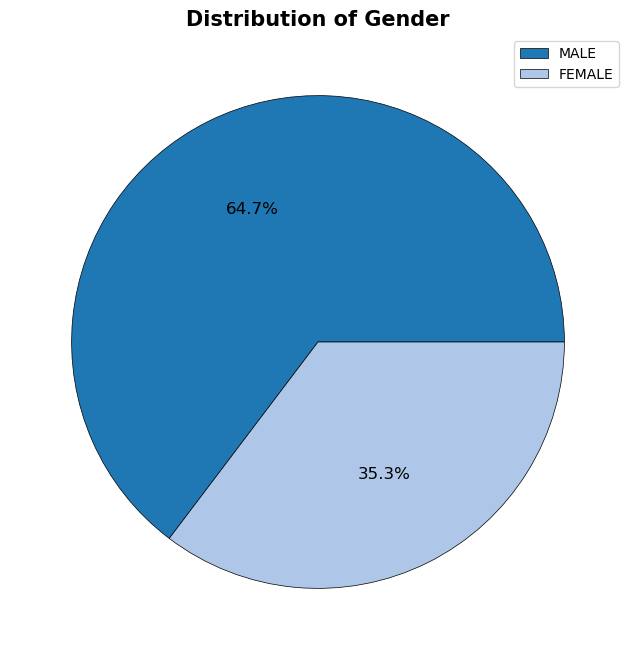

In [162]:
# Plotting value counts of gender with percentages
gender_counts = demographics['gender_source_value'].value_counts()
plt.figure(figsize=(8, 8))

labels = gender_counts.index
colors = plt.cm.tab20(np.arange(len(labels)))  # Obtain colors from the colormap

ax = gender_counts.plot.pie(labels=None, autopct='%.1f%%', colors=colors, fontsize=12, wedgeprops={'linewidth': 0.5, 'edgecolor': 'black'})

plt.ylabel('')
plt.title('Distribution of Gender', fontsize=15, fontweight='bold')
plt.legend(labels, loc='best')  # Add legend with labels and colors
plt.show()

In [65]:
demographics['race_source_value'].value_counts()

WHITE          239
BLACK           26
OTHER           17
ASIAN            2
MULTIRACIAL      1
Name: race_source_value, dtype: int64

/tmp/ipykernel_71935/620688629.py:8: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  ax = race_counts.plot.pie(labels=None, autopct='%.1f%%', colormap='Spectral', colors=colors, fontsize=12)


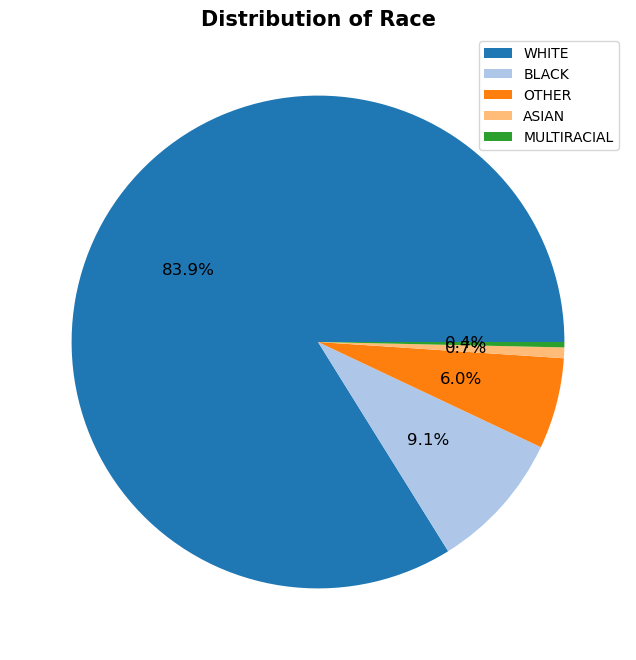

In [118]:
# Plotting value counts of race with percentages
race_counts = demographics['race_source_value'].value_counts()
plt.figure(figsize=(8, 8))  # Adjust the values as per your desired size
# ax = race_counts.plot.pie(autopct='%.1f%%', colormap='bwr')
# ax = race_counts.plot.pie(autopct='%.1f%%', colormap='Spectral')
labels = race_counts.index
colors = plt.cm.tab20(np.arange(len(labels))) 
ax = race_counts.plot.pie(labels=None, autopct='%.1f%%', colormap='Spectral', colors=colors, fontsize=12)

plt.title('Distribution of Race', fontsize=15, fontweight='bold')
plt.ylabel('')
plt.legend(labels, loc='best')
plt.show()

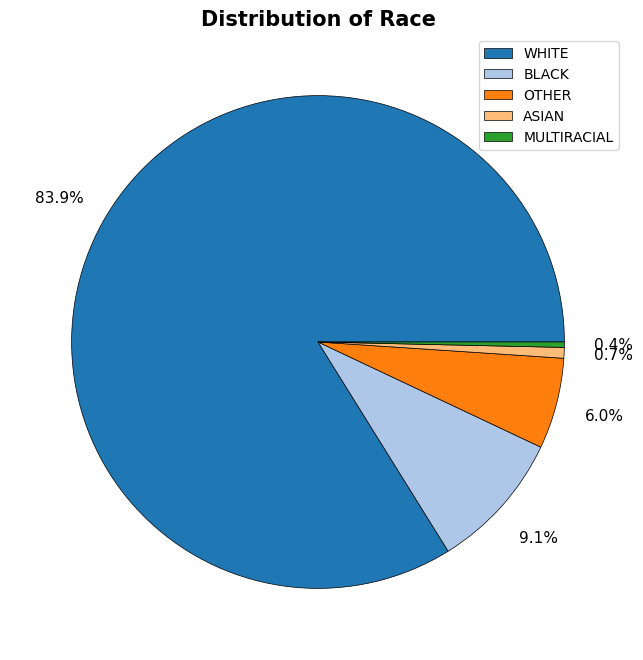

In [161]:
# Plotting value counts of race with percentages
race_counts = demographics['race_source_value'].value_counts()
plt.figure(figsize=(8, 8))

labels = race_counts.index
colors = plt.cm.tab20(np.arange(len(labels))) 
ax = race_counts.plot.pie(labels=None, autopct='%.1f%%', pctdistance=1.2, colors=colors, fontsize=11, wedgeprops={'linewidth': 0.5, 'edgecolor': 'black'})

plt.title('Distribution of Race', fontsize=15, fontweight='bold')
plt.ylabel('')
plt.legend(labels, loc='best')
plt.savefig('pie_chart.png', bbox_inches='tight', pad_inches=0.5)
plt.show()

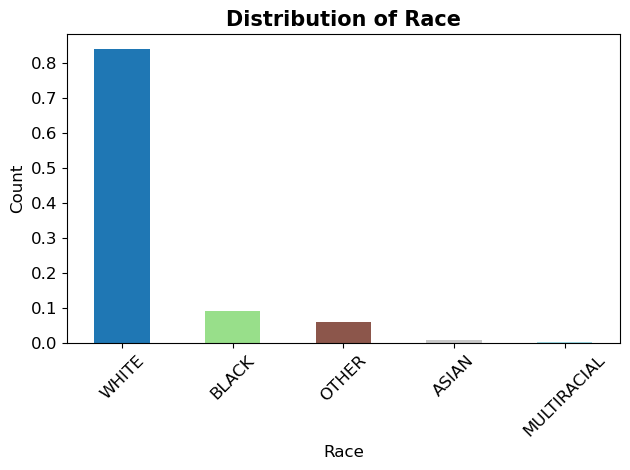

In [164]:
race_counts = demographics['race_source_value'].value_counts(normalize=True)
colormap = cm.get_cmap('tab20')
labels = race_counts.index
colors = colormap(np.linspace(0, 1, len(labels)))

ax = race_counts.plot(kind='bar', color=colors, fontsize=12)

plt.xlabel('Race', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of Race', fontsize=15, fontweight='bold')
# plt.legend(labels, loc='best')
plt.xticks(rotation=45)  # Rotate the x-axis labels by 45 degrees
plt.tight_layout()
plt.show()


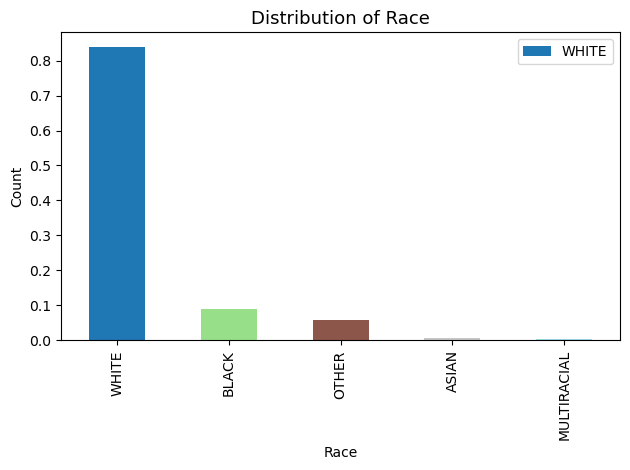

In [153]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

race_counts = demographics['race_source_value'].value_counts(normalize=True)
colormap = cm.get_cmap('tab20')
labels = race_counts.index
colors = colormap(np.linspace(0, 1, len(labels)))

ax = race_counts.plot(kind='bar', color=colors)

plt.xlabel('Race')
plt.ylabel('Count')
plt.title('Distribution of Race')
plt.legend(labels, loc='best', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


In [68]:
demographics['ethnicity_source_value'].value_counts()

NOT HISPANIC    272
HISPANIC         14
Name: ethnicity_source_value, dtype: int64

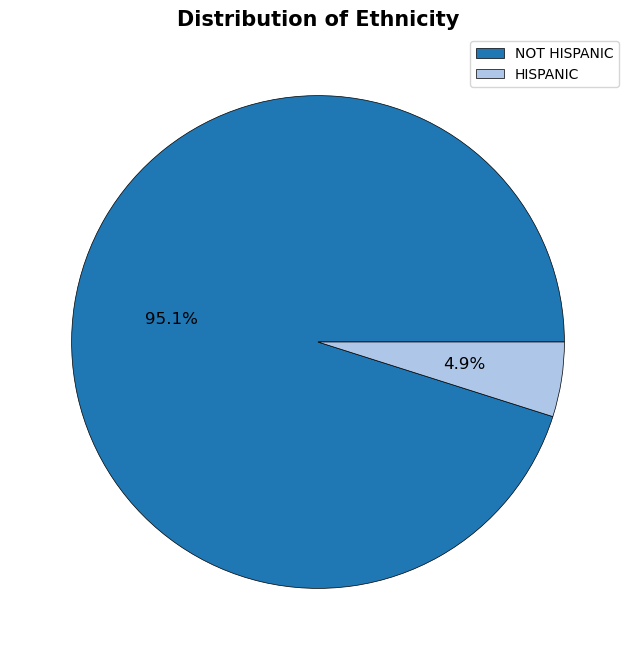

In [174]:
# Plotting value counts of race with percentages
ethnicity = demographics['ethnicity_source_value'].value_counts()
plt.figure(figsize=(8, 8))  # Adjust the values as per your desired size
labels = ethnicity.index
colors = plt.cm.tab20(np.arange(len(labels))) 
ax = ethnicity.plot.pie(labels=None, autopct='%.1f%%', colors=colors, wedgeprops={'linewidth': 0.5, 'edgecolor': 'black'}, fontsize=12)

plt.title('Distribution of Ethnicity', fontsize=15, fontweight='bold')
plt.ylabel('')
plt.legend(labels, loc='best')
plt.show()

In [70]:
df_pd['age'].describe()

count    16040.000000
mean        70.757918
std         13.073931
min         31.000000
25%         64.000000
50%         72.000000
75%         80.000000
max        102.000000
Name: age, dtype: float64

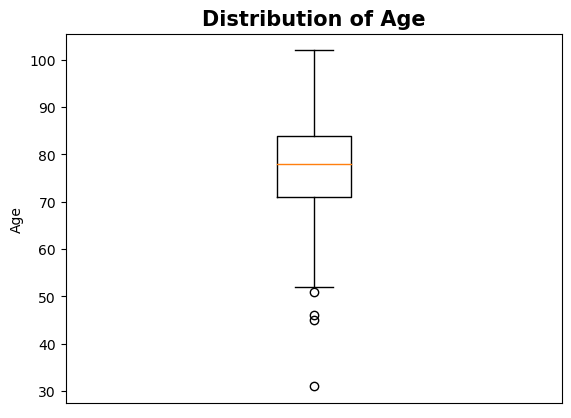

In [173]:
# Plotting the age column using a box plot
plt.boxplot(demographics['age'])
plt.title('Distribution of Age', fontsize=15, fontweight='bold')
plt.ylabel('Age')
plt.xticks([])
plt.show()

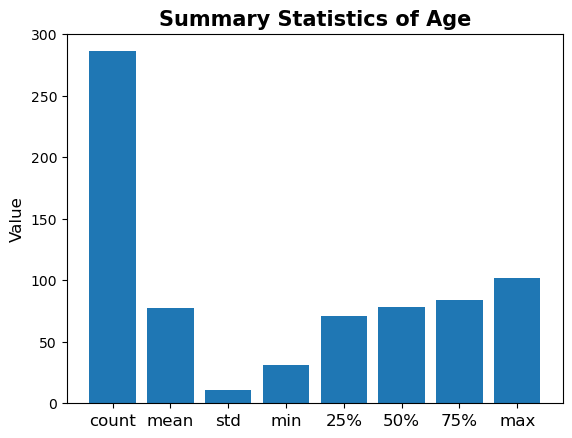

In [178]:
age_summary = demographics['age'].describe()

# Plotting the age column using a bar plot
plt.bar(age_summary.index, age_summary.values)
plt.title('Summary Statistics of Age', fontsize=15, fontweight='bold')
plt.xlabel('', fontsize=12)
plt.xticks(fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.show()

In [73]:
pd_data.value_counts(normalize=True)

generic_name                           brand_name  dosage         
carbidopa-levodopa                     sinemet     25-100 mg          0.462317
                                       sinemet cr  25-100 mg          0.065251
benztropine                            cogentin    1 mg               0.064814
amantadine                             symmetrel   100 mg             0.059944
carbidopa-levodopa                     sinemet     25-250 mg          0.050078
pramipexole                            mirapex     0.25 mg            0.044771
benztropine                            cogentin    0.5 mg             0.035342
carbidopa-levodopa                     sinemet     10-100 mg          0.034093
                                                   12.5-50 mg         0.031033
                                       sinemet cr  50-200 mg          0.030097
benztropine                            cogentin    2 mg               0.014674
entacapone                             comtan      200 mg       

In [74]:
pd_data['brand_name'].value_counts(normalize=True)

sinemet       0.584523
cogentin      0.120347
sinemet cr    0.095217
symmetrel     0.074765
mirapex       0.069340
comtan        0.014965
artane        0.009728
azilect       0.007109
eldepryl      0.004303
duopa         0.003492
stalevo       0.003118
parlodel      0.003055
neupro        0.002681
gocovri       0.001995
parcopa       0.001372
rytary        0.001372
requip        0.000873
lodosyn       0.000686
tasmar        0.000624
dostinex      0.000249
apokyn        0.000187
Name: brand_name, dtype: float64

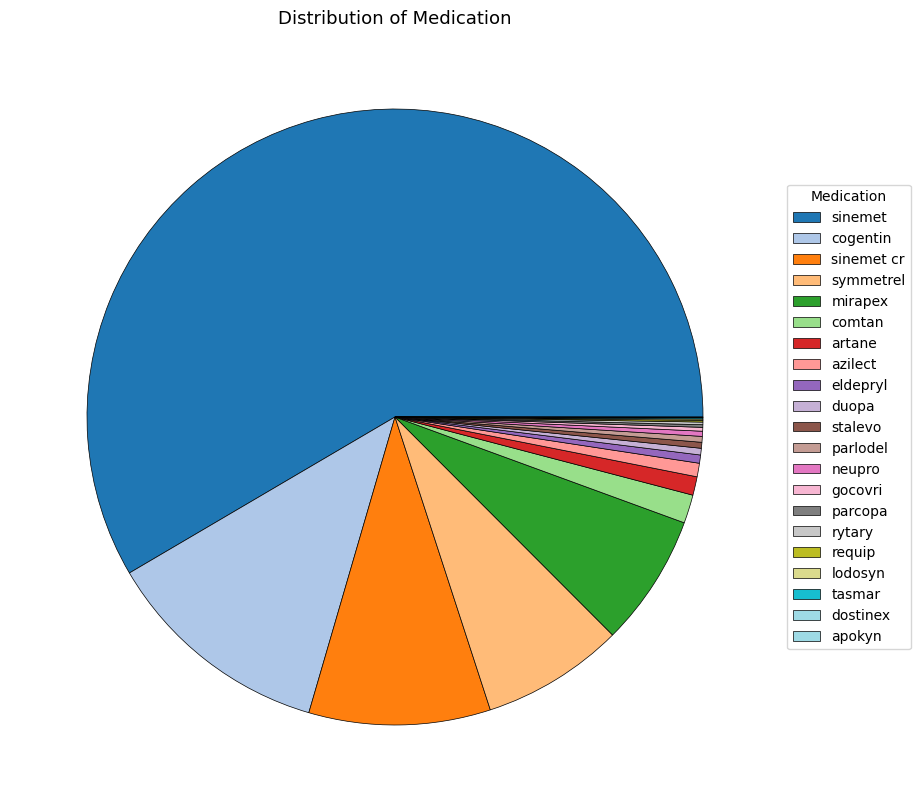

In [185]:
# Plotting value counts of race with percentages
medication_data = pd_data['brand_name'].value_counts()
plt.figure(figsize=(10, 10))  # Adjust the values as per your desired size
# ax = race_counts.plot.pie(autopct='%.1f%%', colormap='bwr')
# ax = race_counts.plot.pie(autopct='%.1f%%', colormap='Spectral')
# Plotting the pie chart without labels inside the pie slices
# Get the number of medications
num_medications = len(medication_data)

# Generate a colormap based on the number of medications
colormap = plt.cm.get_cmap('tab20', num_medications)

# Plotting the pie chart without labels inside the pie slices
_, _, autotexts = plt.pie(medication_data, labels=None, autopct='', pctdistance=1.2, colors=colormap(range(num_medications)), wedgeprops={'linewidth': 0.5, 'edgecolor': 'black'})

plt.title('Distribution of Medication')
plt.legend(medication_data.index, title='Medication', loc='center left', bbox_to_anchor=(1, 0.5))
plt.setp(autotexts, size=8, weight='bold')
plt.axis('off')
plt.show()

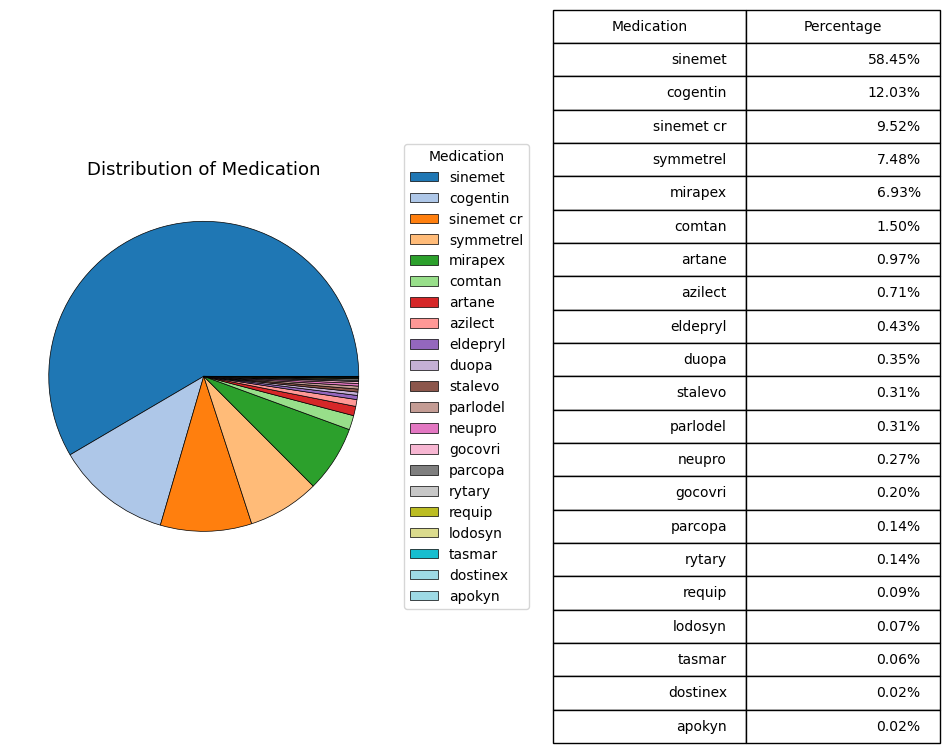

In [186]:
import matplotlib.pyplot as plt

medication_data = pd_data['brand_name'].value_counts()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plotting the pie chart without labels inside the pie slices
wedges, _, autotexts = ax1.pie(medication_data, labels=None, autopct='', colors=plt.cm.tab20(range(len(medication_data))), wedgeprops={'linewidth': 0.5, 'edgecolor': 'black'})

ax1.set_title('Distribution of Medication')
ax1.legend(wedges, medication_data.index, title='Medication', loc='center left', bbox_to_anchor=(1, 0.5))

# Create a table to display the percentages
table_data = [(medication, f'{count / sum(medication_data) * 100:.2f}%') for medication, count in medication_data.items()]
table = ax2.table(cellText=table_data, colLabels=['Medication', 'Percentage'], loc='center')

# Adjust the table appearance
table.scale(1, 2)
table.auto_set_font_size(False)
table.set_fontsize(10)

ax2.axis('off')

plt.subplots_adjust(wspace=0.4)  # Adjust the spacing between subplots
plt.show()


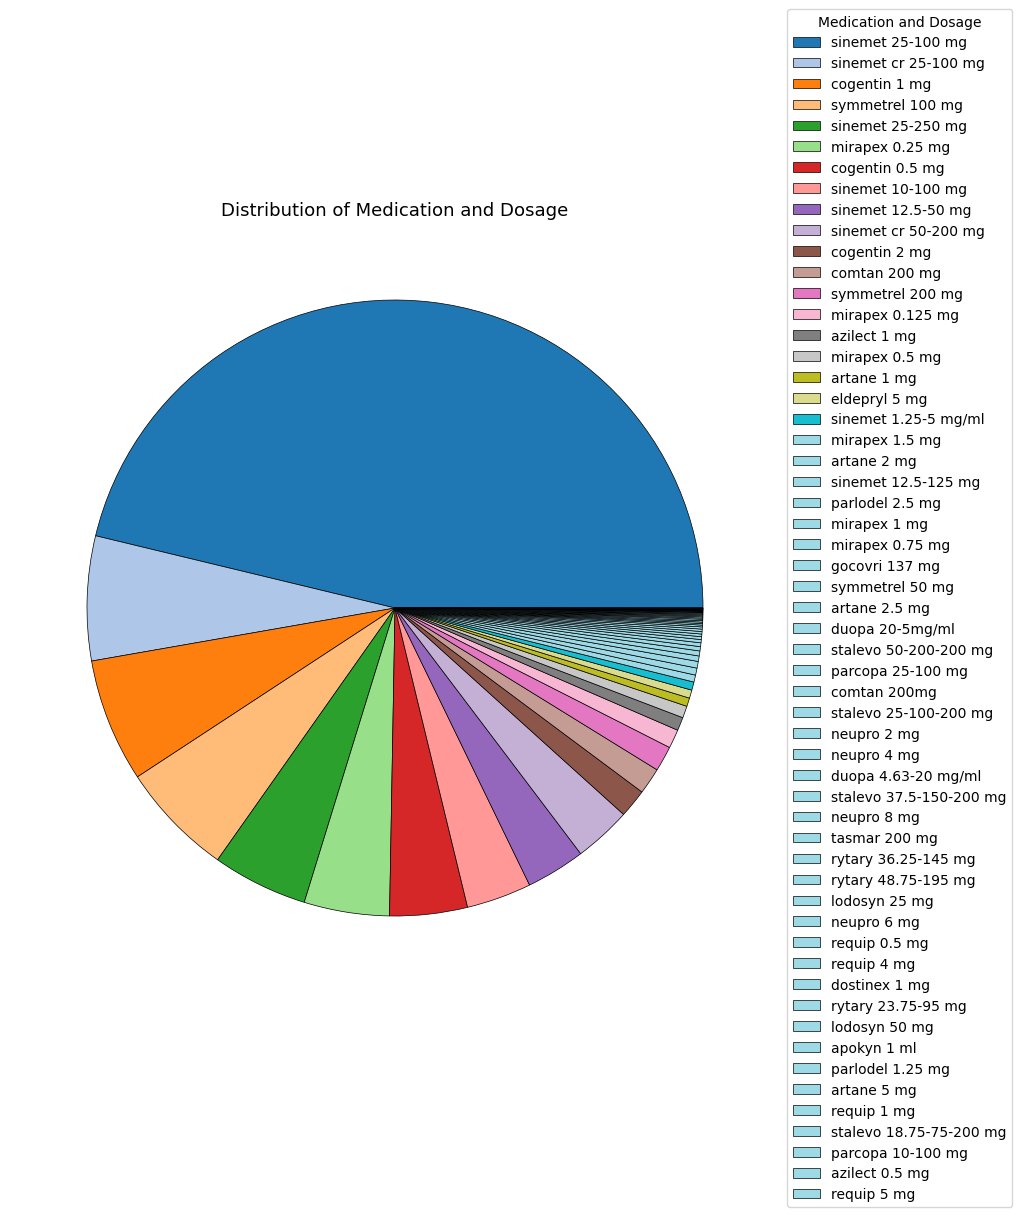

In [197]:
import matplotlib.pyplot as plt

# Combine 'brand_name' and 'dosage' columns
combined_data = pd_data['brand_name'] + ' ' + pd_data['dosage']

# Calculate value counts
medication_data = combined_data.value_counts()

plt.figure(figsize=(10, 10))

# Plotting the pie chart without labels inside the pie slices
_, _, autotexts = plt.pie(medication_data, labels=None, autopct='', colors=plt.cm.tab20(range(len(medication_data))), wedgeprops={'linewidth': 0.5, 'edgecolor': 'black'})

plt.title('Distribution of Medication and Dosage')
plt.legend(medication_data.index, title='Medication and Dosage', loc='center left', bbox_to_anchor=(1, 0.5))
plt.setp(autotexts, size=8, weight='bold')
plt.axis('off')
plt.show()


/tmp/ipykernel_71935/3255805727.py:22: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


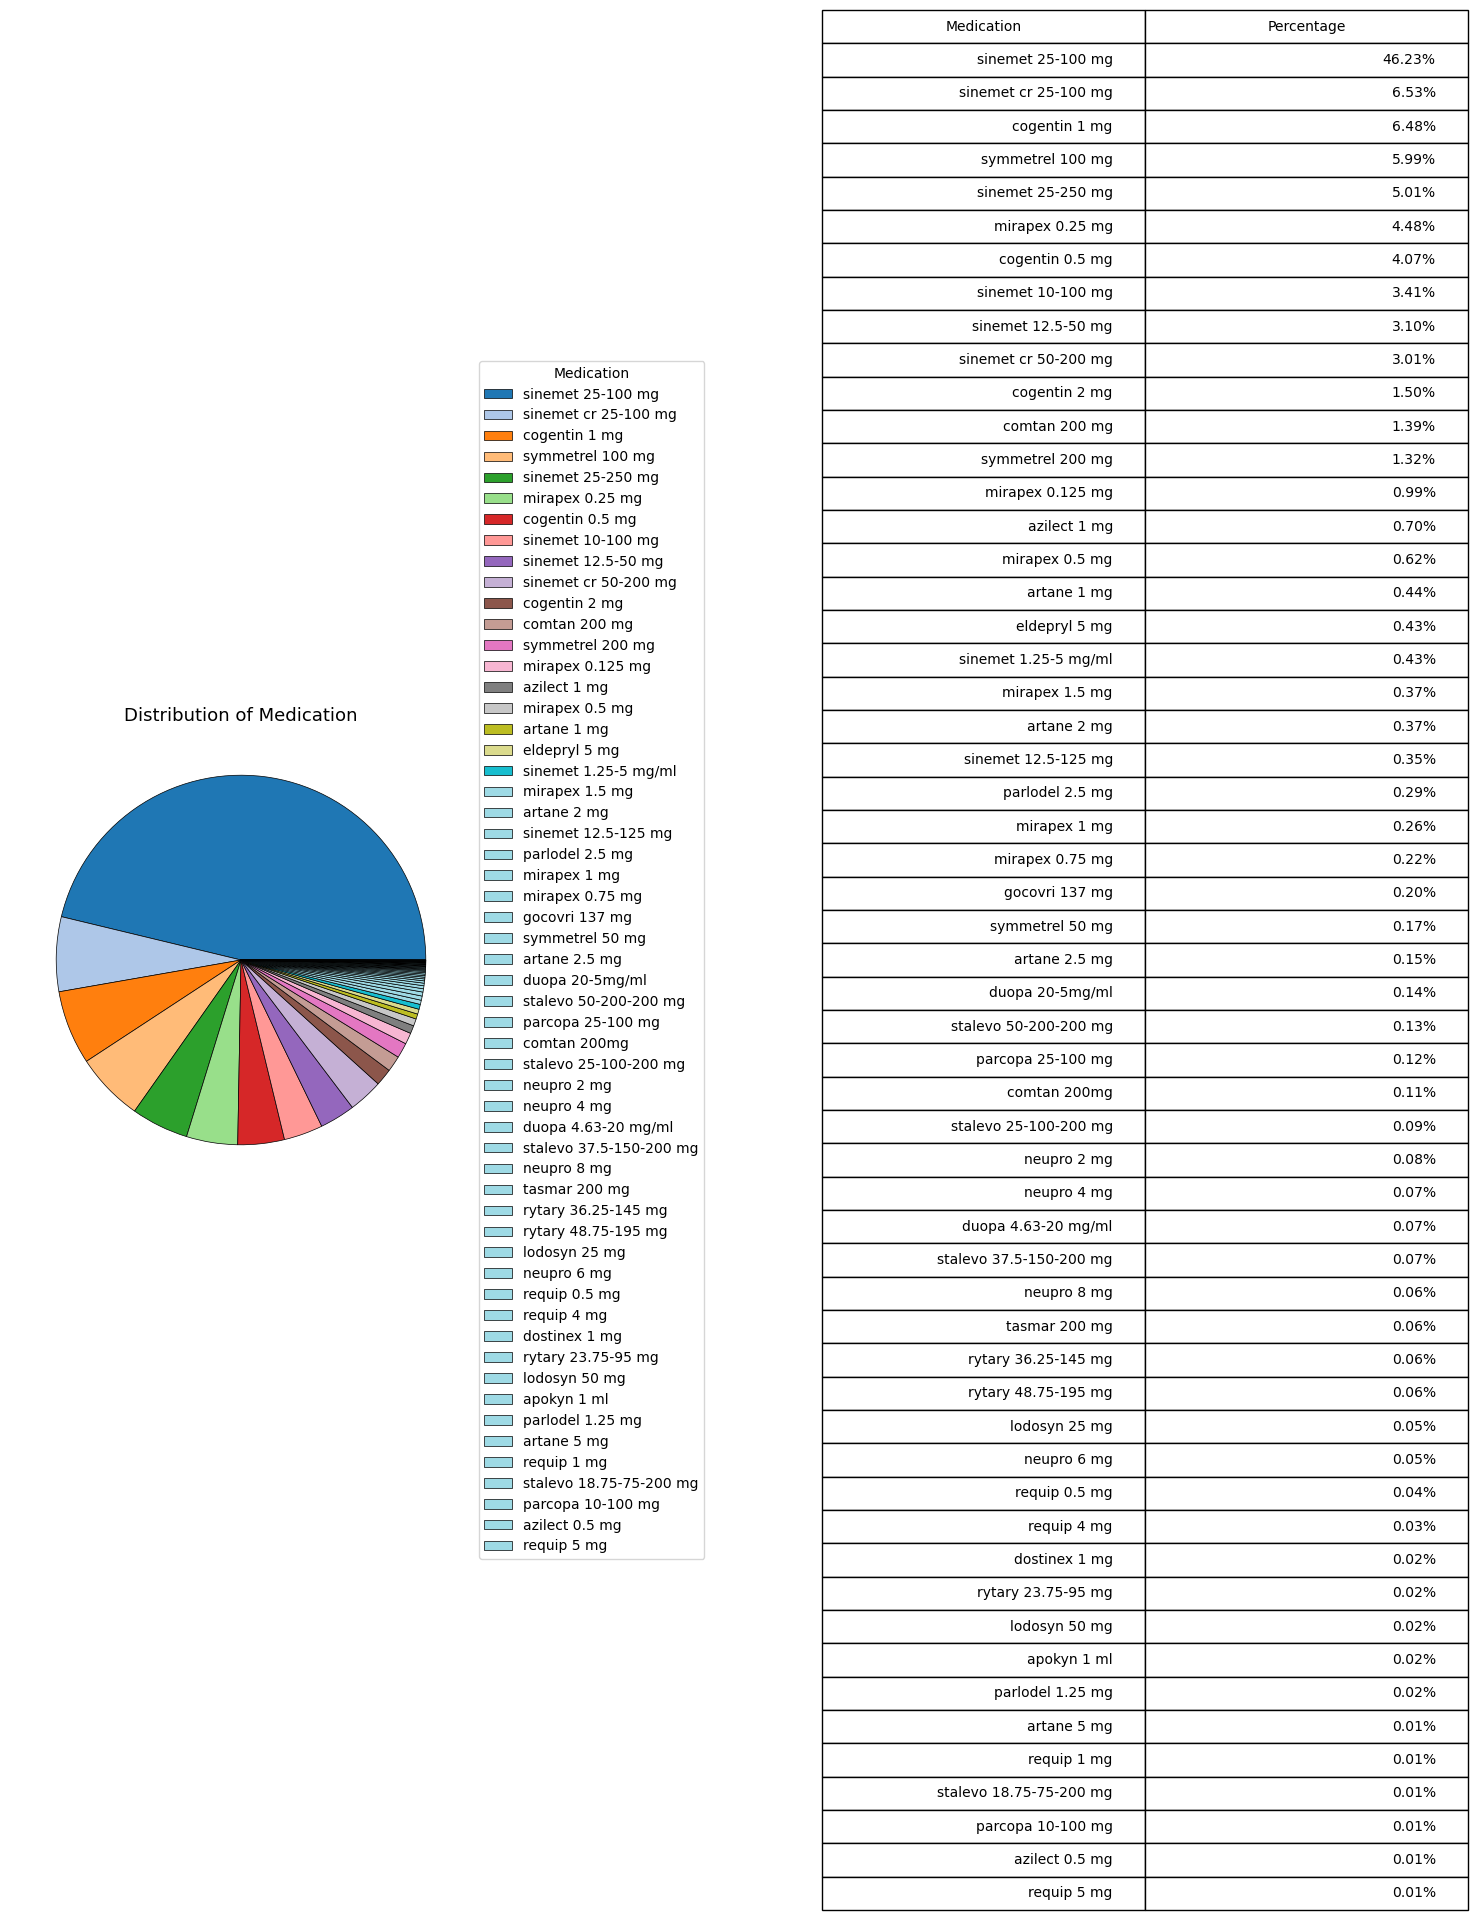

In [195]:
combined_data = pd_data['brand_name'] + ' ' + pd_data['dosage']
medication_data = combined_data.value_counts()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Plotting the pie chart without labels inside the pie slices
wedges, _, autotexts = ax1.pie(medication_data, labels=None, autopct='', colors=plt.cm.tab20(range(len(medication_data))), wedgeprops={'linewidth': 0.5, 'edgecolor': 'black'})

ax1.set_title('Distribution of Medication')
ax1.legend(wedges, medication_data.index, title='Medication', loc='center left', bbox_to_anchor=(1, 0.5))

# Create a table to display the percentages
table_data = [(medication, f'{count / sum(medication_data) * 100:.2f}%') for medication, count in medication_data.items()]
table = ax2.table(cellText=table_data, colLabels=['Medication', 'Percentage'], loc='center')

# Adjust the table appearance
table.scale(1, 2)
table.auto_set_font_size(False)
table.set_fontsize(10)

ax2.axis('off')
plt.tight_layout()
plt.subplots_adjust(wspace=0.4)  # Adjust the spacing between subplots
plt.show()